## Entrenamiento del Modelo LSTM

### Autor: Chavez Aquino, Cecilio

### Librerías

In [1]:
import scipy.io as sio
import numpy as np
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

### Carga y lectura de datos acústicos

In [ ]:
# Dataset: https://www.kaggle.com/datasets/julienjta/engine-acoustic-emissions/data
file_dataset = "D:/Rodamientos/dataset.mat"

# Cargar datos desde el archivo .mat
data = sio.loadmat(file_dataset)

# Extraer señales por clase (cada fila contiene 120000 muestras)
signals_normal = data['normal'].flatten()  # Señales de clase 'normal'
signals_inner = data['inner'].flatten()    # Señales de clase 'inner'
signals_roller = data['roller'].flatten()  # Señales de clase 'roller'
signals_outer = data['outer'].flatten()    # Señales de clase 'outer'

# Crear las etiquetas correspondientes
labels_normal = np.zeros(len(signals_normal))  # Etiqueta 0 para 'normal'
labels_inner = np.ones(len(signals_inner))    # Etiqueta 1 para 'inner'
labels_roller = np.full(len(signals_roller), 2)  # Etiqueta 2 para 'roller'
labels_outer = np.full(len(signals_outer), 3)    # Etiqueta 3 para 'outer'

# Concatenar todas las señales y etiquetas
signals = np.concatenate([signals_normal, signals_inner, signals_roller, signals_outer], axis=0)
labels = np.concatenate([labels_normal, labels_inner, labels_roller, labels_outer], axis=0)

# Confirmar las dimensiones de las señales y etiquetas
print("Dimensiones de las señales:", signals.shape)
print("Dimensiones de las etiquetas:", labels.shape)

# Distribución de clases
unique, counts = np.unique(labels, return_counts=True)
print("Distribución de clases:")
for label, count in zip(unique, counts):
    print(f"Clase {int(label)}: {count} muestras")

Dimensiones de las señales: (480000,)
Dimensiones de las etiquetas: (480000,)
Distribución de clases:
Clase 0: 120000 muestras
Clase 1: 120000 muestras
Clase 2: 120000 muestras
Clase 3: 120000 muestras


### Segmentación de las señales

In [ ]:
fs = 10000  # Frecuencia de muestreo (Hz)
window_duration = 0.2  # Duración del ancho del segmento
window_size = int(fs * window_duration)  # Tamaño de la ventana (número de puntos)

# Función de segmentación corregida
def segment_signals(signals, labels, window_size):
    segmented_signals = []
    segmented_labels = []

    # Índices iniciales para cada clase
    class_indices = [0]  # Inicia en 0
    for i in range(1, len(np.unique(labels))):
        class_indices.append(class_indices[-1] + 120000)  # 120,000 muestras por clase

    for class_id, start_idx in enumerate(class_indices):
        end_idx = start_idx + 120000  # Fin de las muestras para esta clase
        class_signals = signals[start_idx:end_idx]  # Extraer señales de esta clase

        # Generar ventanas para la clase actual
        for i in range(0, len(class_signals), window_size):
            if i + window_size <= len(class_signals):  # Asegurar que no exceda el límite
                segmented_signals.append(class_signals[i:i+window_size])
                segmented_labels.append(class_id)  # Etiqueta de la clase actual

    return np.array(segmented_signals), np.array(segmented_labels)

# Aplicar segmentación corregida
segmented_signals, segmented_labels = segment_signals(signals, labels, window_size)

# Confirmar dimensiones
print("Dimensiones de las señales segmentadas:", segmented_signals.shape)
print("Dimensiones de las etiquetas segmentadas:", segmented_labels.shape)

# Distribución de clases
unique, counts = np.unique(segmented_labels, return_counts=True)
print("Distribución de clases tras segmentación:")
for label, count in zip(unique, counts):
    print(f"Clase {int(label)}: {count} muestras")


Dimensiones de las señales segmentadas: (240, 2000)
Dimensiones de las etiquetas segmentadas: (240,)
Distribución de clases tras segmentación:
Clase 0: 60 muestras
Clase 1: 60 muestras
Clase 2: 60 muestras
Clase 3: 60 muestras


### Aumento de datos

In [ ]:
def add_noise(signals, noise_factor=0.005):
    noisy_signals = signals + noise_factor * np.random.normal(0, 1, signals.shape)
    return np.clip(noisy_signals, -1, 1)  # Limitar valores para evitar saturación

# Función para desplazar señales en el tiempo
def shift_signal(signals, shift=50):
    return np.roll(signals, shift, axis=1)  # Desplazar a la derecha (shift positivo)

# Función para escalar señales
def scale_signal(signals, scale_factor=1.1):
    return signals * scale_factor

# Función para estiramiento temporal
def time_stretch(signals, stretch_factor=1.1):
    stretched_signals = []
    for signal in signals:
        stretched = zoom(signal, stretch_factor, order=1)  # Interpolación lineal
        if len(stretched) > signals.shape[1]:  # Recortar si es más largo
            stretched = stretched[:signals.shape[1]]
        else:  # Rellenar con ceros si es más corto
            stretched = np.pad(stretched, (0, signals.shape[1] - len(stretched)))
        stretched_signals.append(stretched)
    return np.array(stretched_signals)

# Función para desplazamiento de tono (Pitch Shifting)
def pitch_shift(signals, shift_factor=1.05):
    return signals * shift_factor  # Simula cambio de tono modificando frecuencia base

# Aplicar aumento de datos
augmented_signals = []
augmented_labels = []

for signal, label in zip(segmented_signals, segmented_labels):
    # Original
    augmented_signals.append(signal)
    augmented_labels.append(label)

    # Con ruido
    augmented_signals.append(add_noise(signal[np.newaxis, :])[0])
    augmented_labels.append(label)

    # Con desplazamiento temporal
    augmented_signals.append(shift_signal(signal[np.newaxis, :])[0])
    augmented_labels.append(label)

    # Con escalado
    augmented_signals.append(scale_signal(signal[np.newaxis, :])[0])
    augmented_labels.append(label)

    # Con estiramiento temporal
    augmented_signals.append(time_stretch(signal[np.newaxis, :])[0])
    augmented_labels.append(label)

    # Con desplazamiento de tono
    augmented_signals.append(pitch_shift(signal[np.newaxis, :])[0])
    augmented_labels.append(label)

# Convertir a arrays numpy
augmented_signals = np.array(augmented_signals)
augmented_labels = np.array(augmented_labels)

# Confirmar dimensiones tras aumento
print("Dimensiones tras aumento de datos:")
print("Señales:", augmented_signals.shape)
print("Etiquetas:", augmented_labels.shape)

# Verificar distribución de clases
unique, counts = np.unique(augmented_labels, return_counts=True)
print("Distribución de clases tras aumento de datos:")
for label, count in zip(unique, counts):
    print(f"Clase {int(label)}: {count} muestras")


Dimensiones tras aumento de datos:
Señales: (1440, 2000)
Etiquetas: (1440,)
Distribución de clases tras aumento de datos:
Clase 0: 360 muestras
Clase 1: 360 muestras
Clase 2: 360 muestras
Clase 3: 360 muestras


### Estandarización

#### En este caso, la estandarización es recomendable ya que permite que el modelo aprenda patrones temporales sin verse afectado por diferencias en la escala de las amplitudes.

In [ ]:
def standardize_signals(signals):
    mean = np.mean(signals, axis=1, keepdims=True)  # Media por muestra
    std = np.std(signals, axis=1, keepdims=True)    # Desviación estándar por muestra
    standardized_signals = (signals - mean) / (std + 1e-8)  # Normalización evitando división por cero
    return standardized_signals

# Aplicar estandarización
standardized_signals = standardize_signals(augmented_signals)

# Confirmar dimensiones tras la estandarización
print("Dimensiones de las señales estandarizadas:", standardized_signals.shape)

# Verificar estadísticas básicas
print("Media de algunas muestras tras estandarización (esperado ≈ 0):", np.mean(standardized_signals, axis=1)[:5])
print("Desviación estándar de algunas muestras tras estandarización (esperado ≈ 1):", np.std(standardized_signals, axis=1)[:5])


Dimensiones de las señales estandarizadas: (1440, 2000)
Media de algunas muestras tras estandarización (esperado ≈ 0): [-3.06421555e-17 -1.15463195e-17 -2.44249065e-17 -2.22044605e-17
  5.63993297e-17]
Desviación estándar de algunas muestras tras estandarización (esperado ≈ 1): [0.99999987 0.99999987 0.99999987 0.99999988 0.99999986]


### Reformateo de las señales

In [ ]:
lstm_signals = standardized_signals[..., np.newaxis]

# Confirmar dimensiones finales
print("Dimensiones finales de las señales para LSTM:", lstm_signals.shape)
print("Dimensiones de las etiquetas para LSTM:", augmented_labels.shape)

Dimensiones finales de las señales para LSTM: (1440, 2000, 1)
Dimensiones de las etiquetas para LSTM: (1440,)


### Partición de datos (70% 15% 15%)

In [ ]:
train_signals, temp_signals, train_labels, temp_labels = train_test_split(
    lstm_signals, augmented_labels, test_size=0.30, stratify=augmented_labels, random_state=42
)

val_signals, test_signals, val_labels, test_labels = train_test_split(
    temp_signals, temp_labels, test_size=0.50, stratify=temp_labels, random_state=42
)

# Confirmar dimensiones de los conjuntos
print("Dimensiones del conjunto de entrenamiento:", train_signals.shape, train_labels.shape)
print("Dimensiones del conjunto de validación:", val_signals.shape, val_labels.shape)
print("Dimensiones del conjunto de prueba:", test_signals.shape, test_labels.shape)

# Verificar la distribución de clases en cada conjunto
unique_train, counts_train = np.unique(train_labels, return_counts=True)
unique_val, counts_val = np.unique(val_labels, return_counts=True)
unique_test, counts_test = np.unique(test_labels, return_counts=True)

print("\nDistribución de clases en entrenamiento:")
for label, count in zip(unique_train, counts_train):
    print(f"Clase {int(label)}: {count} muestras")

print("\nDistribución de clases en validación:")
for label, count in zip(unique_val, counts_val):
    print(f"Clase {int(label)}: {count} muestras")

print("\nDistribución de clases en prueba:")
for label, count in zip(unique_test, counts_test):
    print(f"Clase {int(label)}: {count} muestras")



Dimensiones del conjunto de entrenamiento: (1008, 2000, 1) (1008,)
Dimensiones del conjunto de validación: (216, 2000, 1) (216,)
Dimensiones del conjunto de prueba: (216, 2000, 1) (216,)

Distribución de clases en entrenamiento:
Clase 0: 252 muestras
Clase 1: 252 muestras
Clase 2: 252 muestras
Clase 3: 252 muestras

Distribución de clases en validación:
Clase 0: 54 muestras
Clase 1: 54 muestras
Clase 2: 54 muestras
Clase 3: 54 muestras

Distribución de clases en prueba:
Clase 0: 54 muestras
Clase 1: 54 muestras
Clase 2: 54 muestras
Clase 3: 54 muestras


### Modelo LSTM

In [ ]:
model = Sequential([
    # Capa Conv1D para extracción de características locales
    Input(shape=(2000, 1)),
    Conv1D(filters=32, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),

    # Primera capa LSTM
    LSTM(64, return_sequences=True, kernel_regularizer='l2'),
    Dropout(0.3),

    # Segunda capa LSTM
    LSTM(32, kernel_regularizer='l2'),
    Dropout(0.3),

    # Capa densa para reducción de dimensionalidad
    Dense(64, activation='relu', kernel_regularizer='l2'),
    Dropout(0.3),

    # Capa de salida
    Dense(4, activation='softmax')
])

# Compilación del modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Resumen del modelo
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 1996, 32)       │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 998, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 998, 64)        │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 998, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,812 (155.52 KB)

 Trainable params: 39,812 (155.52 KB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento del modelo LSTM

In [ ]:
EPOCHS = 20
BATCH_SIZE = 64
# Configurar callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_lstm.keras', monitor='val_loss', save_best_only=True)

# Entrenar el modelo
history = model.fit(
    train_signals, train_labels,  # Datos de entrenamiento
    validation_data=(val_signals, val_labels),  # Datos de validación
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 711ms/step - accuracy: 0.2979 - loss: 3.1214 - val_accuracy: 0.3565 - val_loss: 2.7741
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 601ms/step - accuracy: 0.4539 - loss: 2.6502 - val_accuracy: 0.5880 - val_loss: 2.2232
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 563ms/step - accuracy: 0.5308 - loss: 2.1149 - val_accuracy: 0.5833 - val_loss: 1.7782
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 839ms/step - accuracy: 0.5348 - loss: 1.7706 - val_accuracy: 0.6667 - val_loss: 1.5465
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 878ms/step - accuracy: 0.6088 - loss: 1.6410 - val_accuracy: 0.5139 - val_loss: 1.5912
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 696ms/step - accuracy: 0.4221 - loss: 1.8829 - val_accuracy: 0.6250 - val_loss: 1.5946
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 711ms/step - accuracy: 0.5825 - loss: 1.5173 - val_accuracy: 0.6806 - val_loss: 1.3149
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 654ms/step - accuracy: 0.6497 - loss: 1.3346 - val_accur

### Representación gráfica de la Precisión y la Pérdida en el entrenamiento

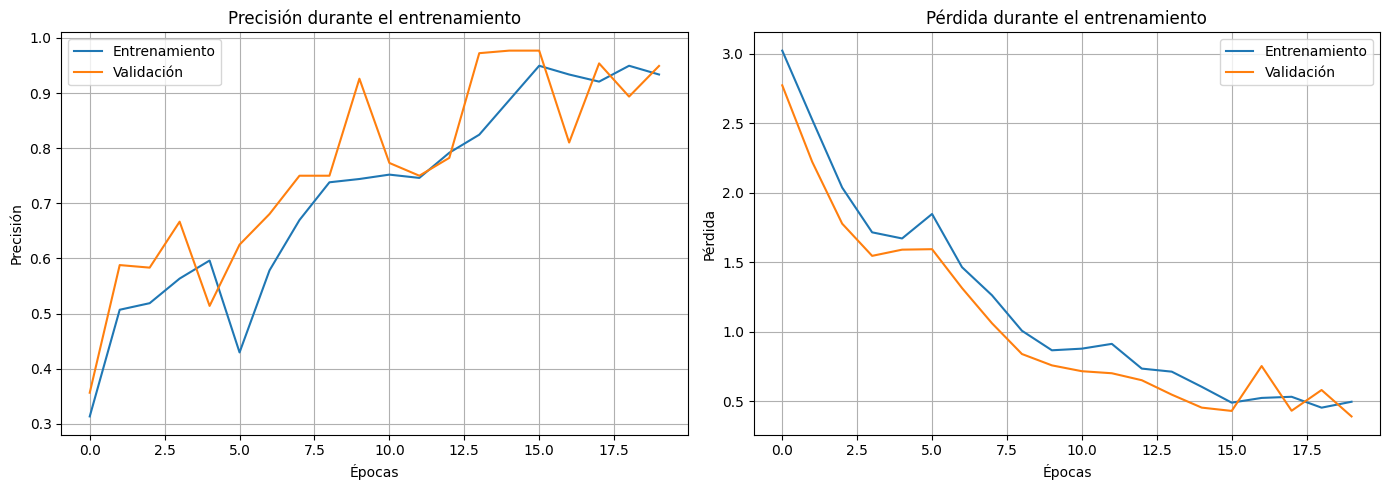

In [ ]:
def plot_training_history(history):
    # Crear subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Gráfico de precisión
    axes[0].plot(history.history['accuracy'], label='Entrenamiento')
    axes[0].plot(history.history['val_accuracy'], label='Validación')
    axes[0].set_title('Precisión durante el entrenamiento')
    axes[0].set_xlabel('Épocas')
    axes[0].set_ylabel('Precisión')
    axes[0].legend()
    axes[0].grid()

    # Gráfico de pérdida
    axes[1].plot(history.history['loss'], label='Entrenamiento')
    axes[1].plot(history.history['val_loss'], label='Validación')
    axes[1].set_title('Pérdida durante el entrenamiento')
    axes[1].set_xlabel('Épocas')
    axes[1].set_ylabel('Pérdida')
    axes[1].legend()
    axes[1].grid()

    # Mostrar gráficos
    plt.tight_layout()
    plt.show()

# Llamar a la función con los resultados del entrenamiento
plot_training_history(history)


### Evaluación del modelo LSTM

In [ ]:
best_model = load_model('best_model_lstm.keras')
test_loss, test_accuracy = best_model.evaluate(test_signals, test_labels, verbose=1)

print(f"Pérdida en prueba: {test_loss:.4f}")
print(f"Precisión en prueba: {test_accuracy:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.9357 - loss: 0.4318
Pérdida en prueba: 0.4319
Precisión en prueba: 0.9352


### Matriz de confusión

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step


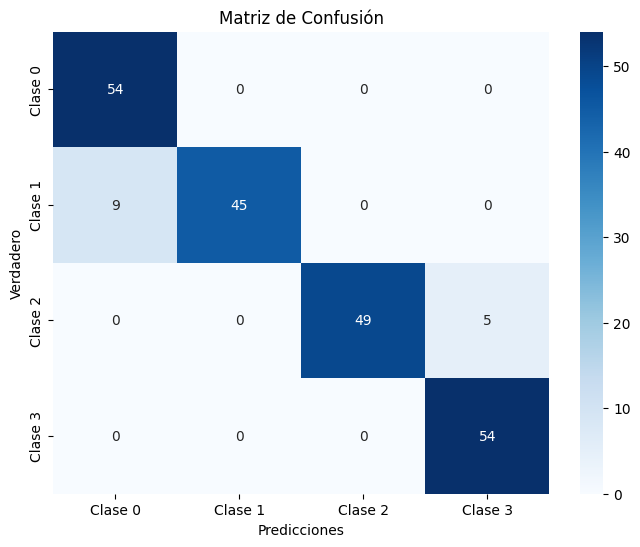

Reporte de clasificación:
              precision    recall  f1-score   support

     Clase 0       0.86      1.00      0.92        54
     Clase 1       1.00      0.83      0.91        54
     Clase 2       1.00      0.91      0.95        54
     Clase 3       0.92      1.00      0.96        54

    accuracy                           0.94       216
   macro avg       0.94      0.94      0.93       216
weighted avg       0.94      0.94      0.93       216



In [ ]:
y_pred = best_model.predict(test_signals)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir probabilidades en clases predichas

# Calcular la matriz de confusión
cm = confusion_matrix(test_labels, y_pred_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1', 'Clase 2', 'Clase 3'], yticklabels=['Clase 0', 'Clase 1', 'Clase 2', 'Clase 3'])
plt.xlabel('Predicciones')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()

# Reporte de clasificación
print("Reporte de clasificación:")
print(classification_report(test_labels, y_pred_classes, target_names=['Clase 0', 'Clase 1', 'Clase 2', 'Clase 3']))

